In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from scipy.io import loadmat
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

In [7]:
n_node = 10 # num of nodes in hidden layer
w_range = [-1, 1] # range of random weights
b_range = [0, 1] # range of random biases

class VariationalBRVFL:
    """ BRVFL Classifier """

    def __init__(self, n_node, alpha_1=10**(-5), alpha_2=10**(-5), alpha_3=10**(-5), alpha_4=10**(-5), n_iter=1000, tol=1.0e-3, activation='sigmoid', same_feature=False):
        self.n_node = n_node
        self.w_range = w_range
        self.b_range = b_range
        
        self.alpha_1 = alpha_1 # Gamma distribution parameter
        self.alpha_2 = alpha_2
        self.alpha_3 = alpha_3
        self.alpha_4 = alpha_4
        self.n_iter = n_iter
        self.tol = tol

        self.model = None
        self.weight = None
        self.bias = None
        self.beta = None
        self.prec = None
        self.var = None
        a = Activation()
        self.activation_function = getattr(a, activation)
        self.data_std = None
        self.data_mean = None
        self.same_feature = same_feature
        self.trace = None
    
    def kernel(self, data, beta, weights, bias):
        h = self.activation_function(T.dot(data, weights) + bias)
        d = T.concatenate([h, data], axis=1)
        d = T.concatenate([d, T.ones_like(d[:, 0:1])], axis=1)
        out = T.dot(d, beta)
        return out

    def train(self, data, label, n_class):
        assert len(data.shape) > 1
        assert len(data) == len(label)
        assert len(label.shape) == 1

        data = self.standardize(data)
        n_sample, n_feature = np.shape(data)
        y = self.one_hot_encoding(label, n_class)

        # Initialize variance and precision using Evidence approximation
        self.model = pm.Model()
        with self.model:
            # make model data aware
            input = pm.Data("input", data)
            output = pm.Data("output", y)

            # build model
            bias = pm.Normal('bias', mu=0, tau=1, shape=(1, self.n_node))
            weights =pm.Normal('weights', mu=0, tau=1, shape=(n_feature, self.n_node))
            precision = pm.Gamma('precision', alpha=self.alpha_1, beta=self.alpha_2)
            variance = pm.Gamma('variance', alpha=self.alpha_3, beta=self.alpha_4)
            beta = pm.Normal('beta', mu=0, tau=precision, shape=(n_feature+self.n_node+1, n_class))
            y_obs = pm.Normal('y_obs', mu=self.kernel(input, beta, weights, bias), tau=variance, observed=output)
            
            # start = pm.find_MAP()
            inference = pm.ADVI()
            approx = pm.fit(n=self.n_iter, method=inference)
            self.trace = approx.sample(draws=5000)

            # train accuracy
            post_pred = pm.sample_posterior_predictive(self.trace, samples=5000)
            y_pred = np.mean(post_pred['y_obs'], axis=0)
            y_pred = np.argmax(y_pred, axis=1)
            acc = np.sum(np.equal(label, y_pred))/len(label)
            print("Train accuracy: ", acc)

    def predict(self, data, raw_output=False):
        data = self.standardize(data) # Normalize

        with self.model:
            # replace data with test set
            pm.set_data({'input': data})
            post_pred = pm.sample_posterior_predictive(self.trace, samples=5000)
            y_pred = np.mean(post_pred['y_obs'], axis=0)
            y_pred = np.argmax(y_pred, axis=1)
        
        return y_pred

    def eval(self, data, label):
        assert len(data.shape) > 1
        assert len(data) == len(label)
        assert len(label.shape) == 1

        y_pred = self.predict(data, False)

        acc = np.sum(np.equal(label, y_pred))/len(label)
        return acc

    def one_hot_encoding(self, label, n_class):
        y = np.zeros([len(label), n_class])
        for i in range(len(label)):
            y[i, label[i]] = 1
        return y

    def standardize(self, x):
        if self.same_feature is True:
            if self.data_std is None:
                self.data_std = np.maximum(np.std(x), 1/np.sqrt(len(x)))
            if self.data_mean is None:
                self.data_mean = np.mean(x)
            return (x - self.data_mean) / self.data_std
        else:
            if self.data_std is None:
                self.data_std = np.maximum(np.std(x, axis=0), 1/np.sqrt(len(x)))
            if self.data_mean is None:
                self.data_mean = np.mean(x, axis=0)
            return (x - self.data_mean) / self.data_std

    def softmax(self, x):
        return np.exp(x) / np.repeat((np.sum(np.exp(x), axis=1))[:, np.newaxis], len(x[0]), axis=1)

class Activation:
    def sigmoid(self, x):
        return 1 / (1 + np.e ** (-x))
    
    def sine(self, x):
        return np.sin(x)
    
    def sign(self, x):
        return np.sign(x)
    
    def relu(self, x):
        return T.maximum(0, x)

In [8]:
dataset = loadmat('coil20.mat')
label = np.array([dataset['Y'][i][0] - 1 for i in range(len(dataset['Y']))])
data = dataset['X']
n_class = len(np.unique(label))
n_node = 10

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

model = VariationalBRVFL(n_node)
model.train(X_train, y_train, n_class)
test_acc = model.eval(X_test, y_test)

Finished [100%]: Average Loss = 5.9277e+06


Train accuracy:  0.1467013888888889


In [9]:
print(test_acc)

0.1111111111111111


In [5]:
dataset = loadmat('coil20.mat')
label = np.array([dataset['Y'][i][0] - 1 for i in range(len(dataset['Y']))])
data = dataset['X']
n_class = len(np.unique(label))

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
# kf = KFold(n_splits=10, shuffle=True, random_state=0)
# val_accs = []
# max_index = -1

# for i, kf_values in enumerate(kf.split(X_train, y_train)):
# #     print(f'train: {train_index}, val: {val_index}')
#     print('Validation: {}'.format(i + 1))
#     train_index, val_index = kf_values
#     X_val_train, X_val_test = X_train[train_index], X_train[val_index]
#     y_val_train, y_val_test = y_train[train_index], y_train[val_index]
#     model = VariationalBRVFL(n_node, w_range, b_range)
#     train_acc, val_acc = model.train(X_val_train, y_val_train, X_val_test, y_val_test, n_class)
#     print(f'Validation accuracy: {val_acc}')
#     val_accs.append(val_acc)
#     if val_acc >= max(val_accs):
#         max_index = train_index

# X_train, y_train = X_train[max_index], y_train[max_index]
# model = VariationalBRVFL(n_node, w_range, b_range)
# model.train(X_train, y_train, X_test, y_test, n_class)
# print(f'\nTest accuracy: {test_acc}')

In [16]:
def standardize(x):
    std = np.maximum(np.std(x, axis=0), 1/np.sqrt(len(x)))
    mean = np.mean(x, axis=0)
    return (x - mean) / std

def one_hot_encoding(label, n_class):
    y = np.zeros([len(label), n_class])
    for i in range(len(label)):
        y[i, label[i]] = 1
    return y

def relu(x):
    return T.maximum(0, x)

def kernel(data, beta, weights, bias):
    h = relu(T.dot(data, weights) + bias)
    d = T.concatenate([h, data], axis=1)
    d = T.concatenate([d, T.ones_like(d[:, 0:1])], axis=1)
    out = T.dot(d, beta)
    return out

def VariationalBayesRVFL(data, label):
    n_node = 10
    alpha_1 = 10**(-5)
    alpha_2 = 10**(-5)
    alpha_3 = 10**(-5)
    alpha_4 = 10**(-5)
    n_iter = 10000

    n_sample, n_feature = np.shape(data)
    x = standardize(data)
    y = one_hot_encoding(label, n_class)

    with pm.Model() as model:
        input = pm.Data("input", x)
        output = pm.Data("output", y)

        bias = pm.Normal('bias', mu=0, tau=1, shape=(1, n_node))
        weights =pm.Normal('weights', mu=0, tau=1, shape=(n_feature, n_node))
        precision = pm.Gamma('precision', alpha=alpha_1, beta=alpha_2)
        variance = pm.Gamma('variance', alpha=alpha_3, beta=alpha_4)
        beta = pm.Normal('beta', mu=0, tau=precision, shape=(n_feature+n_node+1, n_class))
        y_obs = pm.Normal('y_obs', mu=kernel(data, beta, weights, bias), tau=variance, observed=y)

        start = pm.find_MAP()
        inference = pm.ADVI()
        approx = pm.fit(n=n_iter, start=start, method=inference)
        trace = approx.sample(draws=5000)
        post_pred = pm.sample_ppc(trace,samples=5000, model=model)
        y_train_pred = np.mean(post_pred['y_obs'], axis=0)
        y_train_pred = np.argmax(y_train_pred, axis=1)
        train_acc = np.sum(np.equal(y, y_train_pred))/len(label)
        print("Train accuracy: ", train_acc)
        
    return model

model = VariationalBayesRVFL(X_train, y_train)

Interrupted at 4,802 [48%]: Average Loss = 8.0334e+05


AttributeError: module 'pymc3' has no attribute 'sample_ppc'

Text(0.5, 0, 'iteration')

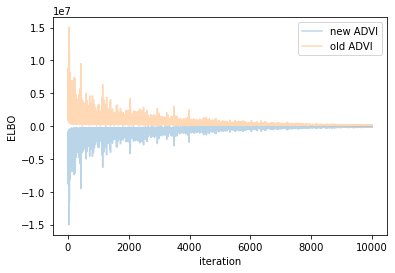

In [9]:
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration")

In [ ]:
def softmax(self, x):
    return np.exp(x) / np.repeat((np.sum(np.exp(x), axis=1))[:, np.newaxis], len(x[0]), axis=1)

def predict(data):
    X_test = standardize(data)
    pm.set_data(new_data={"x": X_test}, model=model)
    y_pred = pm.sample_posterior_predictive(trace, progressbar=True, model=model)
    pred = softmax(y_pred['y_obs'])
    pred = np.argmax(pred, axis=1)
    return pred

def eval(pred, label):
    acc = np.sum(np.equal(pred, label))/len(label)
    return acc
